In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fruit-and-vegetable-image-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F952827%2F3173719%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T175345Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d41ae549c3108cee65f957f6167011d4fe7b84e60b12f7b5169db0dfba3bcb42940f79a2cd546303e118e2fa53614c5d83e22aecabbca15e7838d8431f58a5a5e2cc0d0287c461fca8cc5609e2920164208e1d3ed27c28fbbd3a07ed4078b319bc51804f073ba08f42ab513446e71f262056e5caaa2f230e407083bcd3a03e90fd00918a77d56dbc6537241fef541d710a169ed9966d6b790c8c0eaf894f73850a657b81b339107ff026f853c36351f3fa18e86f86faea9367f98a79efdf6076be4a0a9521d9207011b3b8220070927bbe3f43353c12c6a7559fd80f01dc5f1fda87c8cf506a004f7f974533cd0662224bcc91f512b75e789da50c7d2bb1541'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2130757290 bytes downloaded
Downloaded and uncompressed: fruit-and-vegetable-image-recognition
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_3.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/pear/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/cabbage/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/cabbage/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/test/cabbage/Image_10.jpg
/kaggle/input/fruit-and-veg

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.15.0


In [5]:
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [6]:
test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [8]:
def image_processing(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [9]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [10]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['lemon' 'raddish' 'orange' 'sweetcorn' 'bell pepper' 'lettuce' 'mango'
 'banana' 'pineapple' 'peas' 'cucumber' 'cabbage' 'spinach'
 'chilli pepper' 'cauliflower' 'potato' 'pomegranate' 'beetroot'
 'sweetpotato' 'capsicum' 'pear' 'corn' 'soy beans' 'tomato' 'turnip'
 'carrot' 'kiwi' 'paprika' 'ginger' 'eggplant' 'onion' 'grapes'
 'watermelon' 'apple' 'jalepeno' 'garlic']


In [11]:
train_df.head(5)

,Filepath,Label
0,../input/fruit-and-vegetable-image-recognition...,lemon
1,../input/fruit-and-vegetable-image-recognition...,raddish
2,../input/fruit-and-vegetable-image-recognition...,orange
3,../input/fruit-and-vegetable-image-recognition...,sweetcorn
4,../input/fruit-and-vegetable-image-recognition...,bell pepper


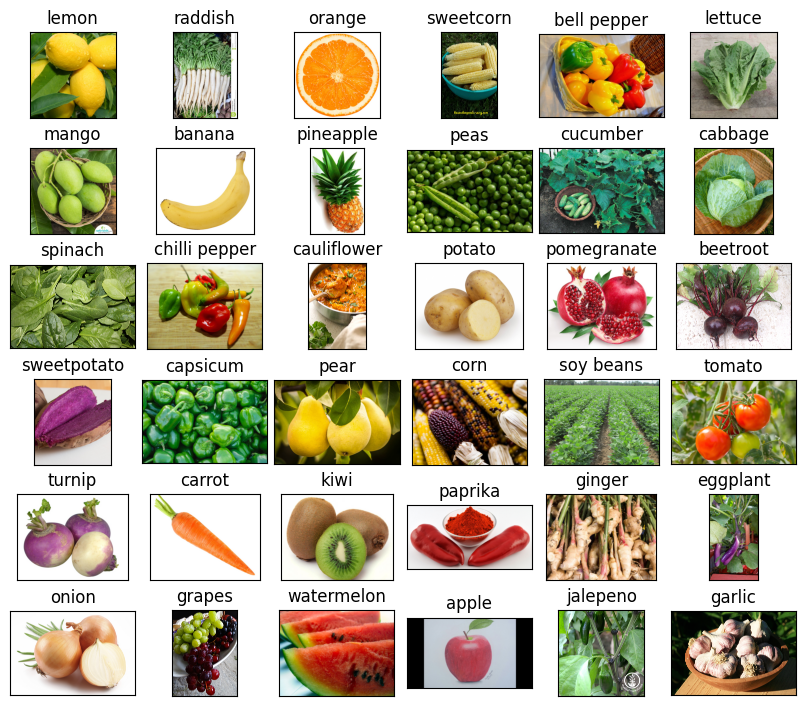

In [12]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [15]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [16]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [18]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 219s 2s/step - loss: 1.8536 - accuracy: 0.5309 - val_loss: 0.5293 - val_accuracy: 0.8563
Epoch 2/5
87/87 [==============================] - 188s 2s/step - loss: 0.5617 - accuracy: 0.8212 - val_loss: 0.2521 - val_accuracy: 0.9222
Epoch 3/5
87/87 [==============================] - 188s 2s/step - loss: 0.3337 - accuracy: 0.8960 - val_loss: 0.2226 - val_accuracy: 0.9371
Epoch 4/5
87/87 [==============================] - 181s 2s/step - loss: 0.2224 - accuracy: 0.9363 - val_loss: 0.1823 - val_accuracy: 0.9371
Epoch 5/5
87/87 [==============================] - 182s 2s/step - loss: 0.1607 - accuracy: 0.9493 - val_loss: 0.1822 - val_accuracy: 0.9491


In [19]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 24s 2s/step


['sweetcorn',
 'cauliflower',
 'onion',
 'chilli pepper',
 'eggplant',
 'tomato',
 'corn',
 'pomegranate',
 'peas',
 'jalepeno',
 'peas',
 'banana',
 'eggplant',
 'orange',
 'apple',
 'pineapple',
 'paprika',
 'watermelon',
 'watermelon',
 'carrot',
 'cucumber',
 'eggplant',
 'paprika',
 'tomato',
 'turnip',
 'spinach',
 'tomato',
 'bell pepper',
 'sweetpotato',
 'capsicum',
 'watermelon',
 'garlic',
 'lettuce',
 'kiwi',
 'pineapple',
 'pineapple',
 'chilli pepper',
 'bell pepper',
 'beetroot',
 'soy beans',
 'pomegranate',
 'raddish',
 'tomato',
 'potato',
 'tomato',
 'capsicum',
 'tomato',
 'mango',
 'carrot',
 'turnip',
 'pineapple',
 'lemon',
 'mango',
 'soy beans',
 'soy beans',
 'kiwi',
 'eggplant',
 'pomegranate',
 'sweetcorn',
 'kiwi',
 'corn',
 'soy beans',
 'watermelon',
 'cauliflower',
 'pear',
 'watermelon',
 'cabbage',
 'jalepeno',
 'soy beans',
 'raddish',
 'peas',
 'beetroot',
 'kiwi',
 'garlic',
 'pear',
 'sweetpotato',
 'bell pepper',
 'bell pepper',
 'pomegranate',
 '

In [20]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

1/1 [==============================] - 1s 902ms/step


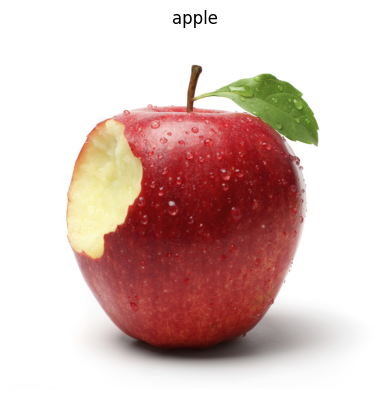

In [21]:
img_path = '/kaggle/input/fruit-and-vegetable-image-recognition/test/apple/Image_1.jpg'
img = output(img_path)
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title(img)
plt.show()

In [22]:
import requests
import json

api_url = 'https://api.api-ninjas.com/v1/nutrition?query={}'.format(img)
response = requests.get(api_url, headers={'X-Api-Key': 'FJCuuMBu83nEaI7CGroR8A==z88oB9CslsPk9p80'})
if response.status_code == requests.codes.ok:
    employee_string = response.text
    json_object = json.loads(employee_string)
    print(json.dumps(json_object[0], indent=4))
else:
    print("Error:", response.status_code, response.text)



{
    "name": "apple",
    "calories": "Only available for premium subscribers.",
    "serving_size_g": "Only available for premium subscribers.",
    "fat_total_g": 0.2,
    "fat_saturated_g": 0.0,
    "protein_g": "Only available for premium subscribers.",
    "sodium_mg": 1,
    "potassium_mg": 11,
    "cholesterol_mg": 0,
    "carbohydrates_total_g": 14.1,
    "fiber_g": 2.4,
    "sugar_g": 10.3
}


In [23]:
model.save('FV.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
